# LocJND — 3-Class Classification Training (full pipeline)

In [21]:
# Core
import random
from pathlib import Path

# Data
import numpy as np
import pandas as pd

# Images
import cv2

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler


# Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Viz
import matplotlib.pyplot as plt


In [22]:
"""
Load blends_meta, map h_c→{0,1,2} via fixed thresholds, split by image_id to avoid leakage.
"""
# Config
META_CSV  = Path("dataset/blends_meta.csv")
B1, B2    = 0.402, 0.648
MARGIN    = 0.05
SEED      = 42
BATCH     = 128
EPOCHS    = 30
LR        = 5e-4
WD        = 5e-4
DEVICE    = "cuda" if torch.cuda.is_available() else "cpu"

def hc_to_cls(h: float) -> int:
    if h < B1 - MARGIN:
        return 0  # Green
    if h >= B2 + MARGIN:
        return 2  # Red
    return 1

meta = pd.read_csv(META_CSV)
meta["label_cls"] = meta["h_c"].astype(float).apply(hc_to_cls)
meta["orig_path"]  = meta["orig_path"].astype(str).apply(lambda p: str(Path(p)))
meta["mixed_path"] = meta["mixed_path"].astype(str).apply(lambda p: str(Path(p)))

# Split strictly by image_id
ids = meta[["image_id"]].drop_duplicates()
train_ids, test_ids = train_test_split(ids, test_size=0.15, random_state=SEED)
train_ids, val_ids  = train_test_split(train_ids, test_size=0.15, random_state=SEED)

train_df = meta.merge(train_ids, on="image_id")
val_df   = meta.merge(val_ids,   on="image_id")
test_df  = meta.merge(test_ids,  on="image_id")

print(f"Train/Val/Test sizes: {len(train_df)} / {len(val_df)} / {len(test_df)}")
print("Class balance (train):", train_df["label_cls"].value_counts().sort_index().to_dict())


Train/Val/Test sizes: 672 / 336 / 336
Class balance (train): {0: 192, 1: 246, 2: 234}


In [23]:
"""
Compute mean/std on TRAIN only for:
- ORIG  (3ch RGB in [0,1])
- MIXED (3ch RGB in [0,1])
- DELTA (abs(mixed-orig), 3ch in [0,1])
"""
def accumulate_stats(df: pd.DataFrame):
    sum_o, sumsq_o = np.zeros(3), np.zeros(3)
    sum_m, sumsq_m = np.zeros(3), np.zeros(3)
    sum_d, sumsq_d = np.zeros(3), np.zeros(3)
    count_px = 0

    for _, r in df.iterrows():
        o = cv2.cvtColor(cv2.imread(r["orig_path"]),  cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
        m = cv2.cvtColor(cv2.imread(r["mixed_path"]), cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
        d = np.abs(m - o)

        H, W, _ = m.shape
        N = H * W
        count_px += N

        X = o.reshape(-1,3); sum_o += X.sum(0); sumsq_o += (X**2).sum(0)
        X = m.reshape(-1,3); sum_m += X.sum(0); sumsq_m += (X**2).sum(0)
        X = d.reshape(-1,3); sum_d += X.sum(0); sumsq_d += (X**2).sum(0)

    def _ms(sum_, sumsq_):
        mean = sum_ / count_px
        var  = sumsq_ / count_px - mean**2
        std  = np.sqrt(np.maximum(var, 1e-12))
        return mean, std

    mean_o, std_o = _ms(sum_o, sumsq_o)
    mean_m, std_m = _ms(sum_m, sumsq_m)
    mean_d, std_d = _ms(sum_d, sumsq_d)
    return mean_o, std_o, mean_m, std_m, mean_d, std_d

mean_o, std_o, mean_m, std_m, mean_d, std_d = accumulate_stats(train_df)
print("ORIG  mean/std:", mean_o, std_o)
print("MIXED mean/std:", mean_m, std_m)
print("DELTA mean/std:", mean_d, std_d)


ORIG  mean/std: [0.46344508 0.46301791 0.30443672] [0.21176087 0.22572452 0.16496973]
MIXED mean/std: [0.46275436 0.46244991 0.30392975] [0.21106215 0.22542388 0.16497163]
DELTA mean/std: [0.00370499 0.00309896 0.00423248] [0.00971612 0.00844022 0.01112117]


In [24]:
"""
Return synchronized (orig, mixed), build delta=|m−o| (3ch), apply per-stream normalization.
Augment only with rot90/flip and keep orig/mixed transforms identical.
"""
class PatchDataset(Dataset):
    def __init__(self, df, mean_o, std_o, mean_m, std_m, mean_d, std_d, augment=False):
        self.df = df.reset_index(drop=True)
        self.mean_o = torch.tensor(mean_o, dtype=torch.float32).view(3,1,1)
        self.std_o  = torch.tensor(std_o,  dtype=torch.float32).view(3,1,1)
        self.mean_m = torch.tensor(mean_m, dtype=torch.float32).view(3,1,1)
        self.std_m  = torch.tensor(std_m,  dtype=torch.float32).view(3,1,1)
        self.mean_d = torch.tensor(mean_d, dtype=torch.float32).view(3,1,1)
        self.std_d  = torch.tensor(std_d,  dtype=torch.float32).view(3,1,1)
        self.augment = augment

    def __len__(self): return len(self.df)

    def _load_rgb(self, p: str) -> np.ndarray:
        x = cv2.imread(p, cv2.IMREAD_COLOR)
        if x is None: raise FileNotFoundError(p)
        return cv2.cvtColor(x, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    def _sync_aug(self, o: np.ndarray, m: np.ndarray):
        if not self.augment: return o, m
        k = random.randint(0, 3)
        if k:
            o = np.rot90(o, k).copy(); m = np.rot90(m, k).copy()
        if random.random() < 0.5:
            o = np.flip(o, 1).copy(); m = np.flip(m, 1).copy()
        if random.random() < 0.5:
            o = np.flip(o, 0).copy(); m = np.flip(m, 0).copy()
        return o, m

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        o = self._load_rgb(r["orig_path"])
        m = self._load_rgb(r["mixed_path"])
        o, m = self._sync_aug(o, m)

        d = np.abs(m - o)  # (H,W,3)

        # to torch, CHW
        o_t = torch.from_numpy(o.transpose(2,0,1))
        m_t = torch.from_numpy(m.transpose(2,0,1))
        d_t = torch.from_numpy(d.transpose(2,0,1))

        # per-stream normalization
        o_t = (o_t - self.mean_o) / (self.std_o + 1e-12)
        m_t = (m_t - self.mean_m) / (self.std_m + 1e-12)
        d_t = (d_t - self.mean_d) / (self.std_d + 1e-12)

        y = int(r["label_cls"])
        return o_t, m_t, d_t, y

train_ds = PatchDataset(train_df, mean_o, std_o, mean_m, std_m, mean_d, std_d, augment=True)
val_ds   = PatchDataset(val_df,   mean_o, std_o, mean_m, std_m, mean_d, std_d, augment=False)
test_ds  = PatchDataset(test_df,  mean_o, std_o, mean_m, std_m, mean_d, std_d, augment=False)

cls_sampling = {0: 1.0, 1: 1.25, 2: 1.35}
sample_weights = train_df["label_cls"].map(cls_sampling).astype(np.float32).to_numpy()
sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True)

train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, pin_memory=True)


In [25]:
"""
Three branches: orig(3ch), mixed(3ch), delta(3ch). Late fusion + dropout head.
Keep capacity moderate; delta branch lighter.
"""
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 20→10, then 10→5 in next block
        )
    def forward(self, x): return self.net(x)

class TinyBranch(nn.Module):
    def __init__(self, in_ch, base=16):
        super().__init__()
        self.b1 = ConvBlock(in_ch, base)       # → 10x10
        self.b2 = ConvBlock(base, base*2)      # → 5x5
    def forward(self, x): return self.b2(self.b1(x))

class PatchNetDual(nn.Module):
    def __init__(self, num_classes=3, base=16, drop=0.3):
        super().__init__()
        self.orig  = TinyBranch(3, base=base)          # out: (base*2,5,5)
        self.mixed = TinyBranch(3, base=base)          # out: (base*2,5,5)
        self.delta = TinyBranch(3, base=base//2)       # out: (base,  5,5)

        f_orig  = (base*2) * 5 * 5
        f_mixed = (base*2) * 5 * 5
        f_delta = (base)   * 5 * 5
        feat_dim = f_orig + f_mixed + f_delta

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat_dim, 256), nn.ReLU(inplace=True),
            nn.Dropout(drop),
            nn.Linear(256, num_classes)
        )

    def forward(self, o, m, d):
        fo = self.orig(o)
        fm = self.mixed(m)
        fd = self.delta(d)
        x  = torch.cat([fo, fm, fd], dim=1)
        return self.head(x)

model = PatchNetDual(num_classes=3, base=16, drop=0.3).to(DEVICE)
print("Params (M):", sum(p.numel() for p in model.parameters())/1e6)


Params (M): 0.550635


In [26]:
"""
CrossEntropyLoss without class-weights (since we oversample via WeightedRandomSampler).
Early-stop on best macro-F1 to protect minority classes.
"""
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WD)

best_state, best_val_f1 = None, -1.0
patience, wait = 8, 0

def run_epoch(dl, train: bool):
    model.train() if train else model.eval()
    tot_loss, tot_ok, tot_n = 0.0, 0, 0
    ys, ps = [], []
    for o, m, d, y in dl:
        o, m, d, y = o.to(DEVICE), m.to(DEVICE), d.to(DEVICE), y.to(DEVICE)
        if train: optimizer.zero_grad()
        logits = model(o, m, d)
        loss   = criterion(logits, y)
        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        pred = logits.argmax(1)
        tot_loss += loss.item() * y.size(0)
        tot_ok   += (pred == y).sum().item()
        tot_n    += y.size(0)
        ys.append(y.detach().cpu().numpy())
        ps.append(pred.detach().cpu().numpy())
    ys = np.concatenate(ys); ps = np.concatenate(ps)
    return tot_loss/tot_n, tot_ok/tot_n, f1_score(ys, ps, average="macro")

for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc, tr_f1 = run_epoch(train_dl, True)
    va_loss, va_acc, va_f1 = run_epoch(val_dl,   False)
    print(f"epoch {ep:02d} | train {tr_loss:.3f}/{tr_acc:.3f}/F1 {tr_f1:.3f} | "
          f"val {va_loss:.3f}/{va_acc:.3f}/F1 {va_f1:.3f}")
    if va_f1 > best_val_f1:
        best_val_f1 = va_f1
        best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
        wait = 0
    else:
        wait += 1
        #if wait >= patience: break

if best_state:
    model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})


epoch 01 | train 1.095/0.344/F1 0.229 | val 1.081/0.324/F1 0.222
epoch 02 | train 1.083/0.390/F1 0.304 | val 1.065/0.363/F1 0.282
epoch 03 | train 1.069/0.406/F1 0.312 | val 1.080/0.342/F1 0.252
epoch 04 | train 1.061/0.396/F1 0.340 | val 1.055/0.372/F1 0.354
epoch 05 | train 1.056/0.412/F1 0.368 | val 1.051/0.390/F1 0.362
epoch 06 | train 1.043/0.475/F1 0.472 | val 1.121/0.357/F1 0.329
epoch 07 | train 1.038/0.504/F1 0.503 | val 1.071/0.381/F1 0.368
epoch 08 | train 1.019/0.518/F1 0.515 | val 1.080/0.393/F1 0.376
epoch 09 | train 1.008/0.513/F1 0.513 | val 1.107/0.381/F1 0.332
epoch 10 | train 0.986/0.510/F1 0.507 | val 1.119/0.384/F1 0.357
epoch 11 | train 0.969/0.548/F1 0.549 | val 1.167/0.384/F1 0.350
epoch 12 | train 0.960/0.551/F1 0.543 | val 1.167/0.372/F1 0.346
epoch 13 | train 0.951/0.548/F1 0.548 | val 1.223/0.348/F1 0.303
epoch 14 | train 0.930/0.571/F1 0.569 | val 1.243/0.354/F1 0.296
epoch 15 | train 0.900/0.591/F1 0.589 | val 1.297/0.351/F1 0.314
epoch 16 | train 0.893/0.

Pred distribution: {0: 168, 1: 95, 2: 73}


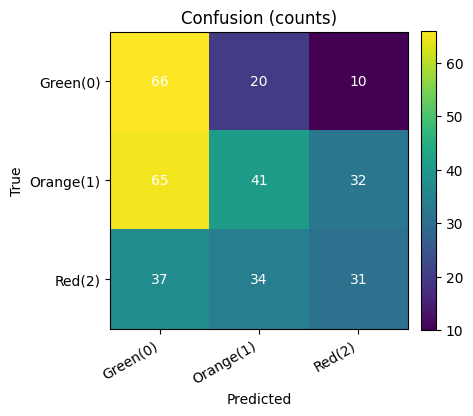

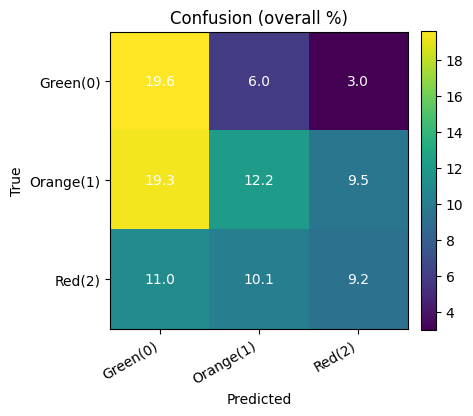

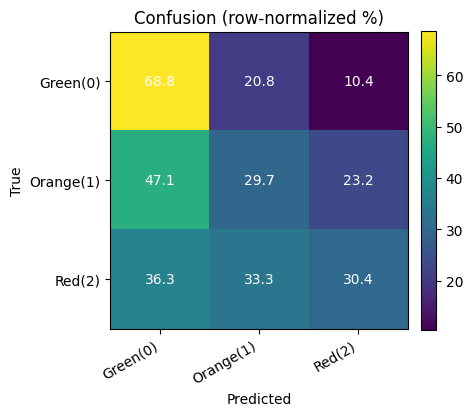

       class  accuracy_pct  support
0   Green(0)         68.75       96
1  Orange(1)         29.71      138
2     Red(2)         30.39      102
              precision    recall  f1-score   support

    Green(0)       0.39      0.69      0.50        96
   Orange(1)       0.43      0.30      0.35       138
      Red(2)       0.42      0.30      0.35       102

    accuracy                           0.41       336
   macro avg       0.42      0.43      0.40       336
weighted avg       0.42      0.41      0.39       336



In [27]:
"""
Test evaluation:
- Confusion matrices: counts, overall %, row-normalized %.
- Per-class accuracy table and full classification report.
- Print prediction distribution for sanity.
"""
model.eval(); y_true, y_pred, probs = [], [], []
with torch.no_grad():
    for o, m, d, y in test_dl:
        logits = model(o.to(DEVICE), m.to(DEVICE), d.to(DEVICE))
        p = torch.softmax(logits, dim=1).cpu().numpy()
        y_true.extend(y.numpy().tolist())
        y_pred.extend(p.argmax(1).tolist())
        probs.extend(p.tolist())

y_true = np.array(y_true); y_pred = np.array(y_pred); probs = np.array(probs)
labels = [0,1,2]; names = ["Green(0)", "Orange(1)", "Red(2)"]

cm_abs = confusion_matrix(y_true, y_pred, labels=labels)
cm_all = confusion_matrix(y_true, y_pred, labels=labels, normalize='all')
cm_row = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')

print("Pred distribution:", pd.Series(y_pred).value_counts().sort_index().to_dict())

def draw_cm(mat, title, is_percent=False):
    fig, ax = plt.subplots(figsize=(4.2,4.0))
    im = ax.imshow(mat if not is_percent else mat*100.0)
    ax.set_xticks(range(len(labels))); ax.set_xticklabels(names, rotation=30, ha='right')
    ax.set_yticks(range(len(labels))); ax.set_yticklabels(names)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat[i, j] * (100 if is_percent else 1)
            ax.text(j, i, f"{val:.1f}" if is_percent else f"{int(val)}",
                    ha='center', va='center', color="w")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04); plt.show()

draw_cm(cm_abs, "Confusion (counts)")
draw_cm(cm_all, "Confusion (overall %)", True)
draw_cm(cm_row, "Confusion (row-normalized %)", True)

per_class_acc = np.diag(cm_row) * 100.0
summary = pd.DataFrame({
    "class": names,
    "accuracy_pct": per_class_acc.round(2),
    "support": [(y_true==i).sum() for i in labels]
})
print(summary)
print(classification_report(y_true, y_pred, labels=labels, target_names=names))


In [28]:
"""
Optional: export predictions for team-wide comparison.
"""
out_csv = Path("runs/test_predictions_dual.csv")
pd.DataFrame({
    "y_true": y_true,
    "y_pred": y_pred,
    "p0": probs[:,0],
    "p1": probs[:,1],
    "p2": probs[:,2],
}).to_csv(out_csv, index=False)
print("Saved:", out_csv.resolve())


Saved: C:\Users\YehonatanR\OneDrive\Documents\HIT Computer Science\3rd\PixelQuality\PythonProject\runs\test_predictions_dual.csv


In [29]:
# Save a single checkpoint file with weights, config, and normalization stats.
ART_DIR = Path("artifacts"); ART_DIR.mkdir(parents=True, exist_ok=True)
CKPT_PATH = ART_DIR / "locjnd_cls.pt"

ckpt = {
    "model_name": "PatchNetDual",
    "arch_params": {"num_classes": 3, "base": 16, "drop": 0.3},
    "config": {
        "B1": B1, "B2": B2, "MARGIN": MARGIN,
        "SEED": SEED, "BATCH": BATCH, "EPOCHS": EPOCHS,
        "LR": LR, "WD": WD, "device": DEVICE,
    },
    "norm": {
        # store as tensors for exact dtype
        "mean_o": torch.tensor(mean_o, dtype=torch.float32),
        "std_o":  torch.tensor(std_o,  dtype=torch.float32),
        "mean_m": torch.tensor(mean_m, dtype=torch.float32),
        "std_m":  torch.tensor(std_m,  dtype=torch.float32),
        "mean_d": torch.tensor(mean_d, dtype=torch.float32),
        "std_d":  torch.tensor(std_d,  dtype=torch.float32),
    },
    "state_dict": model.state_dict(),           # assumes best weights loaded
    "selection_metric": "val_macro_f1",
    "best_val_f1": float(best_val_f1) if "best_val_f1" in locals() else None,
}

torch.save(ckpt, CKPT_PATH)
print("Saved:", CKPT_PATH.resolve())


Saved: C:\Users\YehonatanR\OneDrive\Documents\HIT Computer Science\3rd\PixelQuality\PythonProject\artifacts\locjnd_cls.pt


In [30]:
# Sanity check: load and inspect keys (no new imports needed)
payload = torch.load(CKPT_PATH, map_location="cpu")
print("Keys:", list(payload.keys()))
print("Model:", payload["model_name"], payload["arch_params"])
print("Norm keys:", list(payload["norm"].keys()))
print("Best val macro-F1:", payload["best_val_f1"])


Keys: ['model_name', 'arch_params', 'config', 'norm', 'state_dict', 'selection_metric', 'best_val_f1']
Model: PatchNetDual {'num_classes': 3, 'base': 16, 'drop': 0.3}
Norm keys: ['mean_o', 'std_o', 'mean_m', 'std_m', 'mean_d', 'std_d']
Best val macro-F1: 0.37623667261484756
